
# NYC Census Tracts → NTA Aggregation + Metrics Join

This notebook:

1. Aggregates **census tracts** up to **NTA2020** (Neighborhood Tabulation Area) level.  
2. Joins **NTA-level metrics** (e.g., supply gap, food insecurity) using `nta2020` as the key.

Update the file paths in the first code cell, then run top-to-bottom.


In [8]:

import pandas as pd
import geopandas as gpd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)

# --- EDIT THESE PATHS ---
CENSUS_TRACTS_PATH = "/Users/michelenaorourke/6.C57/nyc_food_supply_gap_analysis/raw/census_tracts.geojson"   # or shapefile, gpkg, etc.

METRICS_CSV        = "/Users/michelenaorourke/6.C57/nyc_food_supply_gap_analysis/raw/Emergency_Food_Supply_Gap_20251110.csv"

# Coordinate Reference Systems
CRS_LATLON    = "EPSG:4326"   # WGS84
CRS_PROJECTED = "EPSG:6539"   # NYC-appropriate projected CRS (meters)


In [2]:

# ---- Load census tracts ----
tracts_path = Path(CENSUS_TRACTS_PATH)
assert tracts_path.exists(), f"Census tracts file not found: {tracts_path}"

tracts = gpd.read_file(tracts_path)
print("Tracts shape:", tracts.shape)
print("Tracts CRS before:", tracts.crs)

if tracts.crs is None:
    print("⚠️ Tracts have no CRS; assuming WGS84 (EPSG:4326).")
    tracts = tracts.set_crs(CRS_LATLON)

tracts_ll = tracts.to_crs(CRS_LATLON)
print("Tracts CRS after:", tracts_ll.crs)
tracts_ll.head(3)


Tracts shape: (2325, 18)
Tracts CRS before: EPSG:4326
Tracts CRS after: EPSG:4326


,:id,:version,:created_at,:updated_at,ctlabel,borocode,boroname,ct2020,boroct2020,cdeligibil,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area,geometry
0,row-n3v9_fibw~s7xp,rv-wmam~mr9u-utmz,2025-08-21 13:56:10.254000+00:00,2025-08-21 13:56:10.254000+00:00,1,1,Manhattan,000100,1000100,I,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,10833.0439286,1843004.52241,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,row-r3ub~566h_ntm6,rv-u9kx_vkcu~bxxk,2025-08-21 13:56:10.254000+00:00,2025-08-21 13:56:10.254000+00:00,14.01,1,Manhattan,001401,1001401,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.33199951,1006116.58954,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,row-7ax4_er4v-39ht,rv-njx8.gskr.fd2m,2025-08-21 13:56:10.254000+00:00,2025-08-21 13:56:10.254000+00:00,14.02,1,Manhattan,001402,1001402,E,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.1560187,1226206.24719,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."


In [3]:
# This notebook expects a column specifically called 'nta2020'
if "nta2020" not in tracts_ll.columns:
    raise KeyError(
        "Column 'nta2020' not found in tracts_ll. "
        "Rename your NTA field to 'nta2020' in the source data or in this notebook before proceeding."
    )

tracts_ll["nta2020"] = tracts_ll["nta2020"].astype(str).str.strip()
tracts_ll["nta2020"].describe()


count       2325
unique       262
top       BK1803
freq          34
Name: nta2020, dtype: object

In [4]:

# ---- Dissolve tracts to NTA polygons ----
nta_geoms = (
    tracts_ll[["nta2020", "geometry"]]
    .dissolve(by="nta2020")
    .reset_index()
)

print("NTA polygons created:", nta_geoms.shape[0])
nta_geoms.head(3)


NTA polygons created: 262


,nta2020,geometry
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232..."
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707..."
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699..."


In [9]:

# ---- Load NTA-level metrics ----
metrics_path = Path(METRICS_CSV)
assert metrics_path.exists(), f"Metrics CSV not found: {metrics_path}"

metrics = pd.read_csv(metrics_path)
print("Metrics shape:", metrics.shape)
print("Metrics columns:", list(metrics.columns))

metrics["nta2020"] = metrics["Neighborhood Tabulation Area NTA)"].astype(str).str.strip()
metrics.drop(["Neighborhood Tabulation Area NTA)"], axis=1, inplace=True)


Metrics shape: (786, 9)
Metrics columns: ['Year', 'Neighborhood Tabulation Area NTA)', 'Neighborhood Tabulation Area (NTA) Name', 'Supply Gap (lbs.)', 'Food Insecure Percentage', 'Unemployment Rate', 'Vulnerable Population Score', 'Weighted Score', 'Rank']


In [10]:
## Choose most recent year for any duplicated NTA id's
# metrics = metrics.loc[idx].reset_index(drop=True)
metrics['Year_DT'] = pd.to_datetime(metrics['Year'], format='%Y')

# Pick the row with the max datetime per nta202
metrics = metrics.loc[metrics.groupby('nta2020')['Year_DT'].idxmax()].reset_index(drop=True)


In [12]:

# ---- Join metrics to NTA geometries ----
nta_with_metrics = nta_geoms.merge(metrics, on="nta2020", how="left")

print("NTA+metrics shape:", nta_with_metrics.shape)
missing_nta = nta_with_metrics["nta2020"].isna().sum()
print("Rows with missing 'nta2020' after merge:", missing_nta)

supply_cols = [c for c in nta_with_metrics.columns if "Supply Gap" in c]
if supply_cols:
    col = supply_cols[0]
    print(f"NTAs missing metrics in '{col}':", nta_with_metrics[col].isna().sum())

nta_with_metrics.head(5)


NTA+metrics shape: (262, 11)
Rows with missing 'nta2020' after merge: 0
NTAs missing metrics in 'Supply Gap (lbs.)': 65


,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank,Year_DT
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0,2025-01-01
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0,2025-01-01
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0,2025-01-01
3,BK0104,"POLYGON ((-73.94042 40.70108, -73.94193 40.700...",2025.0,East Williamsburg,"1,224,484.03196005",21.34%,739.65%,0.42,6.832984,43.0,2025-01-01
4,BK0201,"POLYGON ((-73.99045 40.69372, -73.99059 40.693...",2025.0,Brooklyn Heights,"322,651.410235809",10.05%,407.41%,0.44,5.637125,139.0,2025-01-01


Plotting metric: Supply Gap (lbs.)


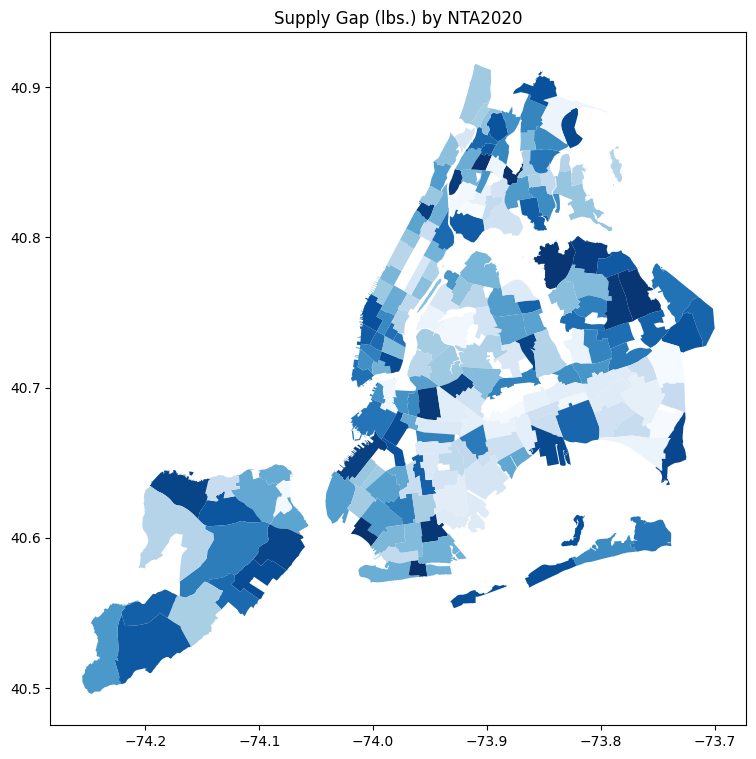

In [13]:

# ---- Optional: quick choropleth of a metric ----
metric_to_plot = None
for c in nta_with_metrics.columns:
    if "Supply Gap" in c:
        metric_to_plot = c
        break

if metric_to_plot is None:
    print("No obvious 'Supply Gap' column found; set metric_to_plot manually.")
else:
    print("Plotting metric:", metric_to_plot)
    ax = nta_with_metrics.plot(
        column=metric_to_plot,
        cmap="Blues",
        figsize=(9, 9),
        edgecolor="none"
    )
    ax.set_title(f"{metric_to_plot} by NTA2020")
    

In [14]:

# ---- Export aggregated NTA+metrics ----
out_dir = Path('data/tabular')
out_dir_geo = Path("data/geo")
out_dir.mkdir(exist_ok=True, parents=True)
out_dir_geo.mkdir(exist_ok=True, parents=True)

nta_with_metrics_ll = nta_with_metrics.to_crs(CRS_LATLON)

In [15]:
nta_with_metrics_ll[nta_with_metrics_ll["Supply Gap (lbs.)"].isna()==False]

,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank,Year_DT
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0,2025-01-01
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0,2025-01-01
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0,2025-01-01
3,BK0104,"POLYGON ((-73.94042 40.70108, -73.94193 40.700...",2025.0,East Williamsburg,"1,224,484.03196005",21.34%,739.65%,0.42,6.832984,43.0,2025-01-01
4,BK0201,"POLYGON ((-73.99045 40.69372, -73.99059 40.693...",2025.0,Brooklyn Heights,"322,651.410235809",10.05%,407.41%,0.44,5.637125,139.0,2025-01-01
...,...,...,...,...,...,...,...,...,...,...,...
252,SI0301,"POLYGON ((-74.11028 40.5515, -74.11098 40.5505...",2025.0,Oakwood-Richmondtown,"529,757.683825265",12.84%,700.09%,0.51,6.203654,89.0,2025-01-01
253,SI0302,"POLYGON ((-74.16175 40.52993, -74.16219 40.530...",2025.0,Great Kills-Eltingville,"1,091,230.79111141",10.42%,533.10%,0.45,6.517951,62.0,2025-01-01
254,SI0303,"POLYGON ((-74.18859 40.54894, -74.1893 40.5483...",2025.0,Arden Heights-Rossville,"600,174.677844235",8.97%,476.47%,0.46,6.042975,100.0,2025-01-01
255,SI0304,"POLYGON ((-74.17779 40.51936, -74.17827 40.519...",2025.0,Annadale-Huguenot-Prince's Bay-Woodrow,"620,825.608054139",8.74%,350.04%,0.47,5.876969,123.0,2025-01-01


In [ ]:
nta_with_metrics_ll.to_file(out_dir_geo / "nta_with_metrics.geojson", driver="GeoJSON")
nta_with_metrics_ll.drop(columns="geometry").to_csv(out_dir / "nta_with_metrics.csv", index=False)

print("Wrote:")
print(" -", out_dir / "nta_with_metrics.geojson")
print(" -", out_dir / "nta_with_metrics.csv")


Wrote:
 - data/tabular/nta_with_metrics.geojson
 - data/tabular/nta_with_metrics.csv



## Next steps

- Extend the dissolve step to also aggregate **numeric tract-level attributes** (e.g., population, SNAP recipients)
  to the NTA level using sum/mean as appropriate.
- Combine this with pantry counts and access metrics for optimization.
